In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

from src.data_prep.Nifty50Dataset import Nifty50Dataset
from src.forecasting.GaussianTransformer import CustomTransformerEncoderOnly
from src.forecasting.StockSeriesForcaster import StockSeriesForecaster
from src.forecasting.StockSeriesForcasterEncoder import StockSeriesForecasterEncoder

model = CustomTransformerEncoderOnly(d_model=4, nhead=2, num_encoder_layers=6, dim_feedforward=256)

dataset = Nifty50Dataset(
    "/Users/maniksomayaji/Documents/omscs/capstone_project/data/NIFTY 50_minute_data.csv",
    window_size=60,
    prediction_horizon=1
)

split_ratio = 0.2
val_size = int(len(dataset) * split_ratio)
train_size = len(dataset) - val_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

forecaster = StockSeriesForecasterEncoder(model, optimizer, criterion)


[Epoch 1 | Batch 50] Loss: 3.3100
[Epoch 1 | Batch 100] Loss: 3.3785
[Epoch 1 | Batch 150] Loss: 2.2570
[Epoch 1 | Batch 200] Loss: 0.8486
[Epoch 1 | Batch 250] Loss: 6.3070
[Epoch 1 | Batch 300] Loss: 3.0536
[Epoch 1 | Batch 350] Loss: 0.7275
[Epoch 1 | Batch 400] Loss: 1.4049
[Epoch 1 | Batch 450] Loss: 0.3134
[Epoch 1 | Batch 500] Loss: 2.7097
[Epoch 1 | Batch 550] Loss: 0.5552
[Epoch 1 | Batch 600] Loss: 0.3430
[Epoch 1 | Batch 650] Loss: 2.0455
[Epoch 1 | Batch 700] Loss: 0.5276
[Epoch 1 | Batch 750] Loss: 0.3358
[Epoch 1 | Batch 800] Loss: 0.3487
[Epoch 1 | Batch 850] Loss: 0.5526
[Epoch 1 | Batch 900] Loss: 1.8200
[Epoch 1 | Batch 950] Loss: 0.8000
[Epoch 1 | Batch 1000] Loss: 0.7393
[Epoch 1 | Batch 1050] Loss: 3.4634
[Epoch 1 | Batch 1100] Loss: 0.5543
[Epoch 1 | Batch 1150] Loss: 1.5141
[Epoch 1 | Batch 1200] Loss: 1.2253
[Epoch 1 | Batch 1250] Loss: 3.3064
[Epoch 1 | Batch 1300] Loss: 0.9980
[Epoch 1 | Batch 1350] Loss: 3.9171
[Epoch 1 | Batch 1400] Loss: 0.2141
[Epoch 1 | B

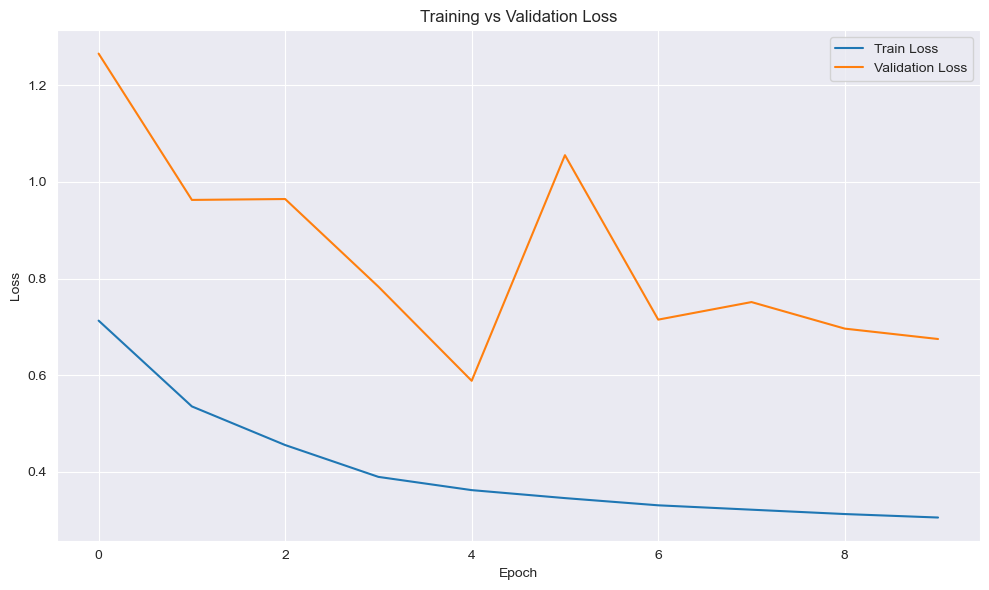

In [2]:
train_loss, val_loss = forecaster.train(train_loader, val_loader, epochs=10)

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [3]:
num_batches = 3
for i, (x, y) in enumerate(train_loader):
    if i >= num_batches:
        break
    output = forecaster.autoregressive_predict(x, max_len=20)
    print("Generated:", output)

Generated: tensor([[15107.1289, 15108.3506, 15111.6553, 15114.6230, 15120.9893, 15133.9395,
         15135.3242, 15135.8545, 15136.4316, 15137.0732, 15137.8398, 15138.8682,
         15140.4990, 15143.3760, 15146.3232, 15148.0723, 15149.4082, 15150.6914,
         15152.3623, 15153.9229],
        [10430.4863, 10430.6924, 10430.8076, 10430.8613, 10430.8682, 10430.8125,
         10430.6729, 10430.4570, 10430.1807, 10429.8115, 10429.0820, 10426.0332,
         10410.1826, 10411.9355, 10410.9795, 10410.5947, 10410.1025, 10409.5879,
         10409.0420, 10408.4795]])
Generated: tensor([[10340.7578, 10344.5879, 10348.3662, 10350.8330, 10350.9385, 10350.3604,
         10349.4111, 10348.6328, 10348.0469, 10347.6113, 10347.5127, 10347.4873,
         10347.1533, 10345.9219, 10341.2998, 10334.5771, 10333.6934, 10333.3301,
         10333.0068, 10332.7061],
        [15394.4863, 15399.7783, 15407.3623, 15412.5537, 15412.7686, 15411.4580,
         15401.8184, 15396.5176, 15396.1406, 15395.7588, 15395.33

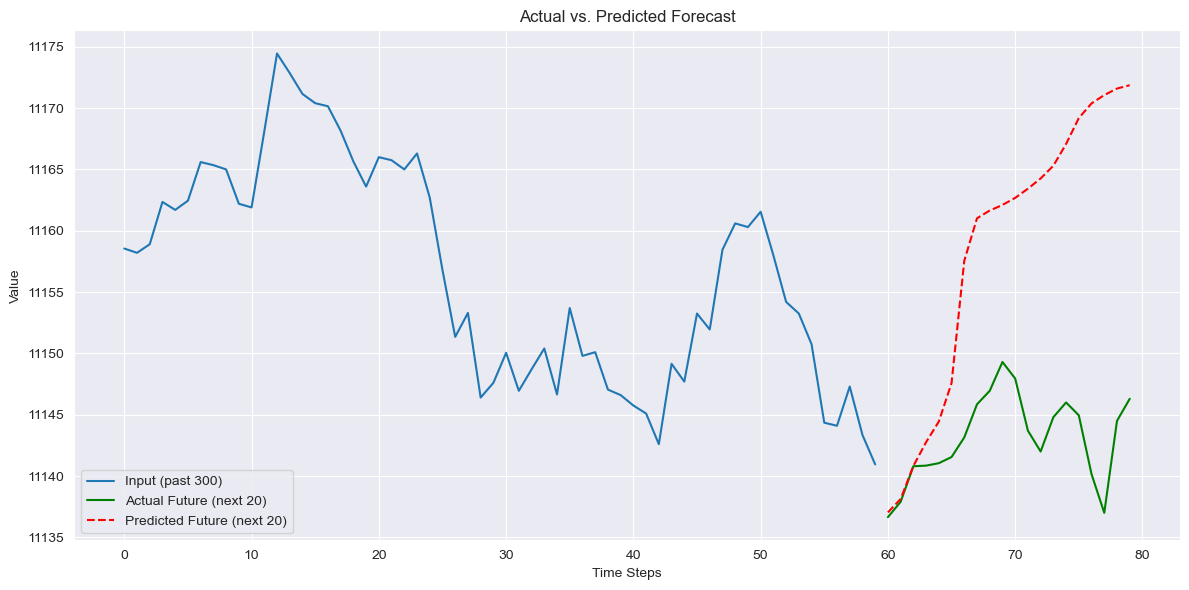

In [11]:
import matplotlib.pyplot as plt
import torch

predict_dataset = Nifty50Dataset(
    "/Users/maniksomayaji/Documents/omscs/capstone_project/data/NIFTY 50_minute_data.csv",
    window_size=80,
    prediction_horizon=1
)

data_x, data_y = predict_dataset[10000]

input_seq = data_x[:60].unsqueeze(0)
true_future = data_x[60:]

with torch.no_grad():
    predicted_future = forecaster.autoregressive_predict(input_seq, max_len=20)
predicted_future = predicted_future.squeeze().unsqueeze(-1) # Remove batch dimension

plt.figure(figsize=(12, 6))
plt.plot(range(60), input_seq.squeeze(), label='Input (past 300)')
plt.plot(range(60, 80), true_future, label='Actual Future (next 20)', color='green')
plt.plot(range(60, 80), predicted_future, label='Predicted Future (next 20)', color='red', linestyle='--')
plt.legend()
plt.title('Actual vs. Predicted Forecast')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
torch.save(model.state_dict(), 'model_l_1.pth')

In [12]:
forecaster1 = StockSeriesForecaster(model, optimizer, criterion)
train_loss, val_loss = forecaster1.train(train_loader, val_loader)

KeyboardInterrupt: 

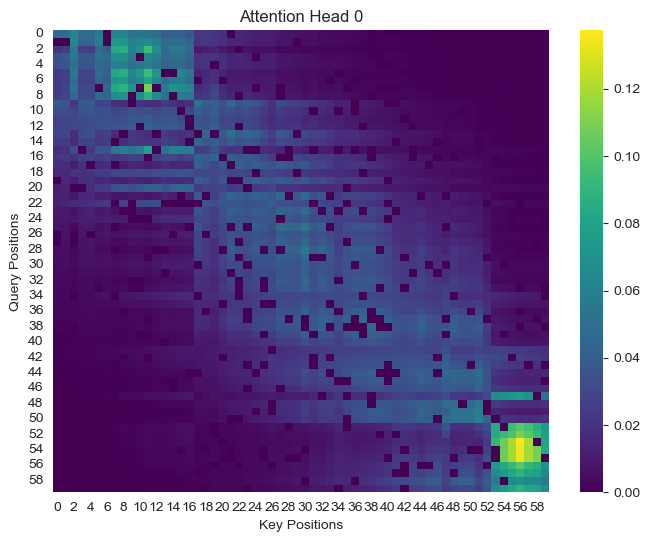

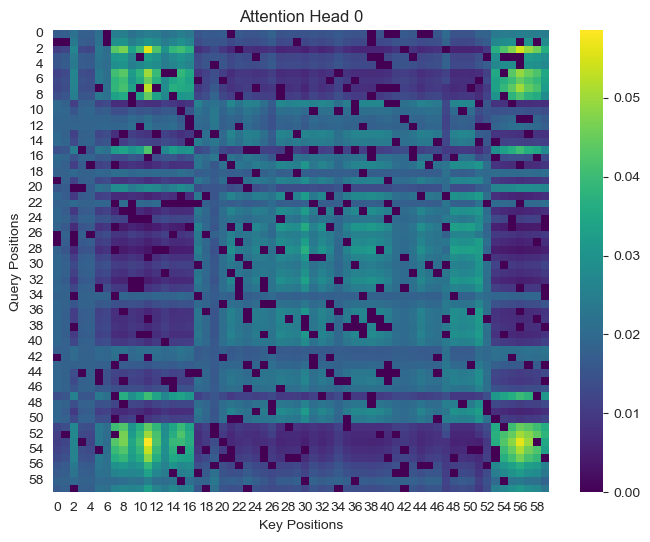

In [5]:
first_encoder_layer = model.encoder.layers[2]
attn_weights = first_encoder_layer.self_attn.guass_attn_weights_for_plot
raw_attn_weights = first_encoder_layer.self_attn.raw_attn_weights_for_plot

import matplotlib.pyplot as plt
import seaborn as sns

# Pick the first head
head_id = 0
attention = attn_weights[0, head_id].numpy()  # shape: (Tq, Tk)

plt.figure(figsize=(8, 6))
sns.heatmap(attention, cmap="viridis")
plt.title(f"Attention Head {head_id}")
plt.xlabel("Key Positions")
plt.ylabel("Query Positions")
plt.show()

head_id = 0
raw_attention = raw_attn_weights[0, head_id].numpy()

plt.figure(figsize=(8, 6))
sns.heatmap(raw_attention, cmap="viridis")
plt.title(f"Attention Head {head_id}")
plt.xlabel("Key Positions")
plt.ylabel("Query Positions")
plt.show()